In [1]:
import glob
import json
import os
import time

import detectron2
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import numpy as np
import torch

ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

from detectron2_classes.DetectionDatasetMapper import DetectionDatasetMapper
from inference import register_inference_instances
import koger_general_functions as kgf

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
# Name of model folder to use for inference
model_name = "full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"

In [1]:
# name of observation to process
observation_name = "observation088"

# ---------------------------------------
# Automatic image loading based on specific file structure of multi-drone observations
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)
frame_files = kgf.get_observation_frame_files(frame_folders_root)

print(f"Processing {len(frame_files)} frames.")

save_root = os.path.join(local_paths['processed_folder'], observation_name)
os.makedirs(save_root, exist_ok=True)
print(f"Saving at: {save_root}")

In [5]:
# Load model and modify config for inference
models_folder = os.path.join(os.path.dirname(os.getcwd()), 
                             'model-training', 'output')
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

cfg = get_cfg()

with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(models_folder, model_name, 
                           "best-model-config-iter-*.pth"))
)
cfg.MODEL.WEIGHTS = weights_path[-1]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [6]:
# Use all paths in frame_files for inference
register_inference_instances("inference", frame_files)
mapper = DetectionDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "inference", mapper=mapper)

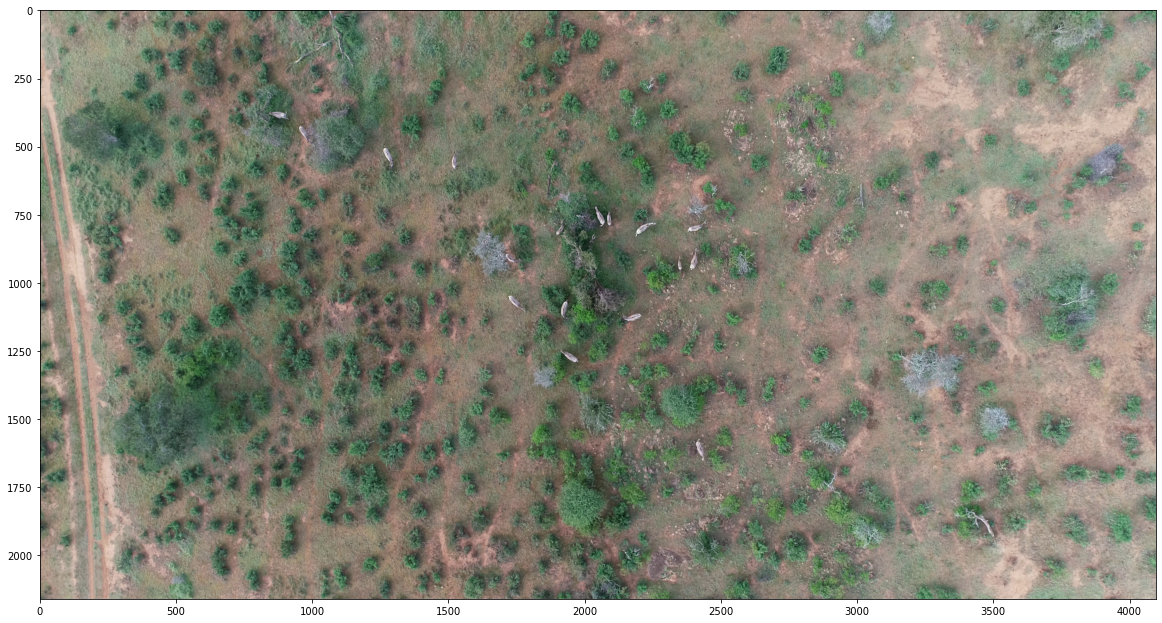

In [7]:
# Display first image just to confirm the expected images loaded
for batch in loader:
    image = batch[0]['image'].numpy()
    image = np.transpose(image, [1, 2, 0])
    plt.figure(figsize=(20, 20))
    plt.imshow(image[..., ::-1].astype(np.uint8))
    break

In [9]:
# build the model
model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

In [10]:
all_detections = []

t = time.time()
with torch.no_grad():
    for batch_num, image_batch in enumerate(loader):
        if batch_num % 1000 == 0:
            cur_time = time.time()
            print(f"{batch_num} images processed. fps: {batch_num/(cur_time-t)}")
        detections = model(image_batch)

        detection_dict = detections[0]['instances'].get_fields()
        detection_dict['pred_boxes'] = detection_dict['pred_boxes'].tensor.cpu().numpy()
        detection_dict['scores'] = detection_dict['scores'].cpu().numpy()
        detection_dict['pred_classes'] = detection_dict['pred_classes'].cpu().numpy()
        detection_dict['image_name'] = os.path.basename(image_batch[0]['file_name'])
        all_detections.append(detection_dict)

np_detections_file = os.path.join(save_root, '{}_detections.npy'.format(observation_name))
np.save(np_detections_file, all_detections)
            
print(time.time() - t)

0 images processed. fps: 0.0


/home/golden/detectron2aug16/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


42.00680923461914


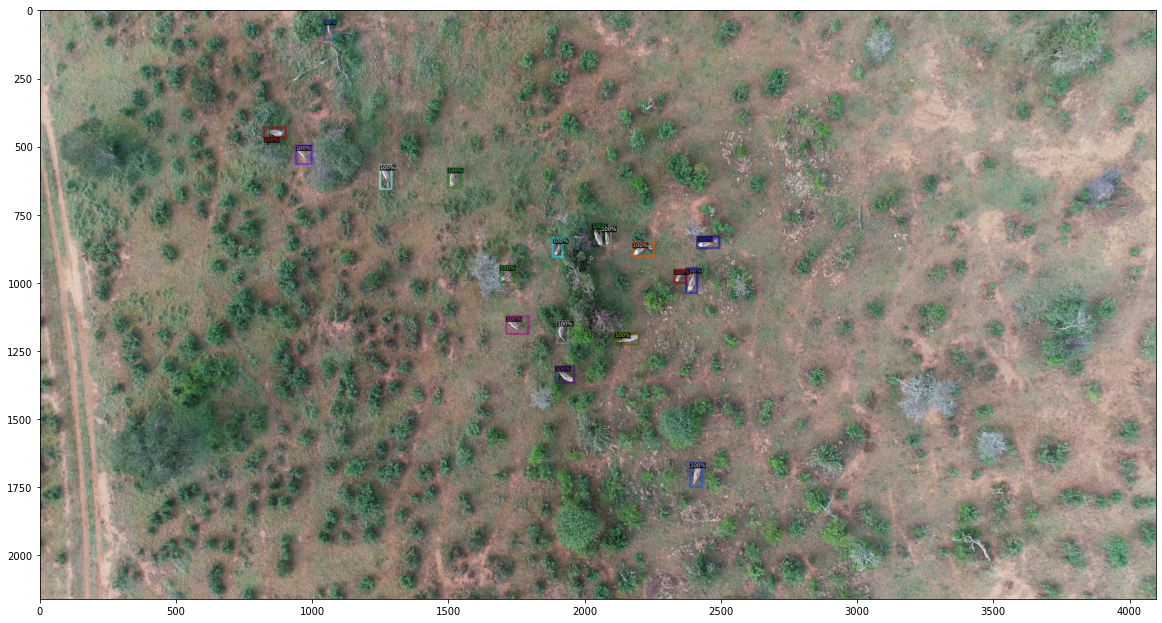

In [11]:
image = image_batch[0]['image'].numpy()
image = np.transpose(image, [1, 2, 0])

v = Visualizer(image[...,::-1],
               metadata=None,
               scale=1.0,
)
v = v.draw_instance_predictions(detections[0]['instances'])
plt.figure(figsize=(20,20))
plt.imshow(v.get_image())